In [2]:
import sys
sys.path.append('/home/cb/sis2/')

with open('../env.txt') as f:
    ENVIRONMENT = f.readlines()[0][:-1]
print(f'running on environment: "{ENVIRONMENT}"')
assert ENVIRONMENT in ['blaze',
                       'colab',
                       'local',
                       'cpom']

import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

sys.path.append(os.path.expanduser('~/.snap/snap-python'))
import snappy
from snappy import ProductIO
from snappy import jpy
HashMap = snappy.jpy.get_type('java.util.HashMap')

sys.path.append('../')
import sis_toolbox as tbx
import preprocessing.snap_toolbox as stbx

from datetime import datetime
datetime_string = datetime.now().strftime("%m%d-%H%M")

if ENVIRONMENT == 'cpom':
    PATH_DATA = '/home/cb/sis2/data/'
elif ENVIRONMENT == 'local':
    PATH_DATA = '/Users/christianboehm/projects/sis2/data/'

TILESIZE = 256
# TILESIZE = 960

index = 177


img_pairs_inventory = pd.read_csv(os.path.join(PATH_DATA, 'inventory/img_pairs.csv'), index_col='index').loc[[index]]

# for index, row in img_pairs_inventory.iterrows():

row = img_pairs_inventory.loc[index]


running on environment: "cpom"


In [3]:

# if not (pd.isna(img_pairs_inventory['status'].iloc[index]) or img_pairs_inventory['status'].iloc[index] == 'new'):
#     status = row['status']
#     print(f'index {index} skipped due to status \'{status}\'')
#     continue

S2_FILE = row['s2']
S3_FILE = row['s3']
print(row['s2'])
print(row['s3'])

s2_raw = ProductIO.readProduct(S2_FILE)
s3_raw = ProductIO.readProduct(S3_FILE)


/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_2/DATA/S2B_MSIL1C_20220418T173859_N0400_R098_T17XPA_20220418T205558.SAFE
/cpnet/projects/sikuttiaq/pond_inlet/Sentinel_3/OLCI/2022/04/S3A_OL_1_EFR____20220418T162117_20220418T162417_20220419T213709_0179_084_197_1800_MAR_O_NT_002.SEN3


In [36]:
tile1 = stbx.region_subset(s2_raw, '1000,8000,8500,1000')
tile2 = stbx.region_subset(s2_raw, '2000,4000,3000,3000')
tile3 = stbx.region_subset(s2_raw, '1000,3000,3000,3000')


<class 'list'>


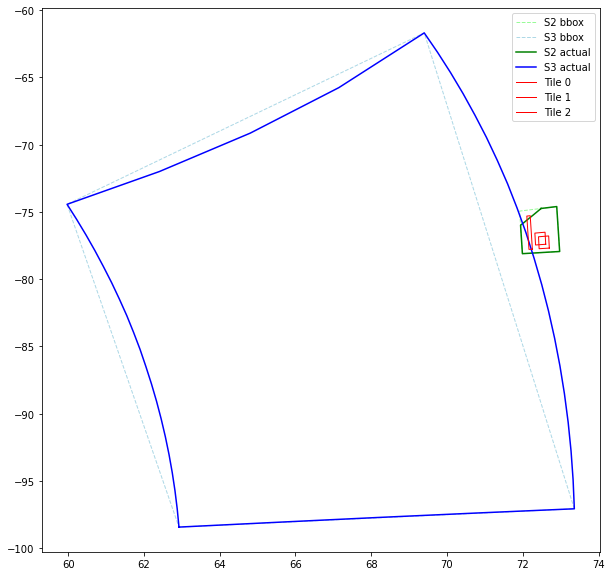

In [37]:
import importlib
importlib.reload(stbx)
stbx.plot_polygons(s2_raw, s3_raw, [tile1, tile2, tile3])


In [17]:
stbx.check_overlap(s2_raw, s3_raw, 'metadata.s2', 'metadata.s3')


0.9999999999999997

In [ ]:

s2_bands = stbx.band_subset(s2_raw, 'B2,B3,B4,B_opaque_clouds')
s3_bands = stbx.band_subset(s3_raw, 'Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,Oa07_radiance,Oa08_radiance,Oa09_radiance,Oa10_radiance,Oa11_radiance,Oa12_radiance,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance')
s2_bands = stbx.resample(s2_bands, 'B2')
collocated = stbx.collocate(s2_bands, s3_bands)
collocated = stbx.band_subset(collocated,'B2,B3,B4,Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,Oa07_radiance,Oa08_radiance,Oa09_radiance,Oa10_radiance,Oa11_radiance,Oa12_radiance,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance,B_opaque_clouds,quality_flags,collocationFlags')

s2_polygon = stbx.get_metadata_polygon(s2_raw, 's2')
s3_polygon = stbx.get_metadata_polygon(s3_raw, 's3')


In [3]:
TILE_XPOS = 12
TILE_YPOS = 8103
tilesize = TILESIZE
file_index = f'{index:05d}'
product = collocated
cloud_threshold = 1.0
ensure_intersect_with = [s2_polygon, s3_polygon]
intersect_threshold = 0.95
output_path = PATH_DATA

tile_inventory = pd.DataFrame(columns=['pair_index', 'tile', 'size', 'status', 'comment', 'filename'])
tile_inventory = tile_inventory.astype({'pair_index': str,
                    'tile': str,
                    'size': int,
                    'status': str,
                    'comment': str,
                    'filename': str})

# TILE_XPOS = x_offset+x*x_step
# TILE_YPOS = y_offset+y*y_step
TILECODE = f'{TILE_XPOS}x{TILE_YPOS}'
output_tif = f'tif{tilesize}/{file_index}_{TILECODE}.tif'
status = 'ok'
comment = ''

# if os.path.exists(os.path.join(PATH_DATA, output_filename)):
#     tif_inventory = tif_inventory.append({'img_pair_id': TILE_PREFIX,
#                             'tile': TILECODE,
#                             'size': TILESIZE,
#                             'tif_status': 'exists'}, ignore_index=True)
#     print(f'File {output_filename} already exists')
#     continue

try:
    region = f'{TILE_XPOS},{TILE_YPOS},{tilesize},{tilesize}'
    tile = stbx.region_subset(product, region)

    cloud_array = stbx.nparray(tile, 'B_opaque_clouds')
    cloudpct = np.sum(cloud_array) / np.size(cloud_array)
    if cloudpct > cloud_threshold:
        status = 'quality'
        comment = f'cloud coverage: {int(cloudpct * 100)}%'

    tile_polygon = stbx.get_bbox_polygon(tile)
    for i in range(len(ensure_intersect_with)):
        intersect = tile_polygon.intersection(ensure_intersect_with[i]).area / tile_polygon.area
        if intersect < intersect_threshold:
            status = 'intersect'
            comment = f'Intersect with item {i}: {int(intersect * 100)}%'
            
    # black_array_s2 = nparray(tile, 'B2')
    # blackpct_s2 = np.count_nonzero(black_array_s2 == -0.1) / np.size(black_array_s2)
    # if blackpct_s2 > 0.05:
    #     status = 'quality'
    #     comment = f'S2 black: {int(blackpct_s2 * 100)}%'

    black_array_s3 = stbx.nparray(tile, 'Oa17_radiance')
    max_value = np.max(black_array_s3)
    blackpct_s3 = np.count_nonzero(black_array_s3 == max_value) / np.size(black_array_s3)
    if blackpct_s3 > 0.05:
        status = 'quality'
        comment = f'S3 (likely) black: {int(blackpct_s3 * 100)}%'

    if status == 'ok':
        ProductIO.writeProduct(tile, os.path.join(output_path, output_tif), 'GeoTIFF')
    else:
        ProductIO.writeProduct(tile, os.path.join(output_path, output_tif + 'x'), 'GeoTIFF')
    
    tile_inventory = tile_inventory.append({'pair_index': file_index,
                            'tile': TILECODE,
                            'size': tilesize,
                            'status': status,
                            'comment': comment,
                            'filename': output_tif}, ignore_index=True)
        
except Exception as e:
    tile_inventory = tile_inventory.append({'pair_index': file_index,
                            'tile': TILECODE,
                            'size': tilesize,
                            'status': 'error',
                            'comment': str(e)}, ignore_index=True)


In [4]:
tile_inventory

,pair_index,tile,size,status,comment,filename
0,00013,12x8103,256,ok,,tif256/00013_12x8103.tif


In [5]:
# import importlib
# importlib.reload(snap_toolbox)

In [ ]:
tile_list, quality_list = stbx.cut_tiles(collocated,
                                                    tilesize=TILESIZE,
                                                    file_index=index,
                                                    output_path=PATH_DATA,
                                                    ensure_intersect_with=[s2_polygon,s3_polygon])


In [ ]:

    img_pairs_inventory.loc[index, 'status'] = 'tifs created'
    img_pairs_inventory.to_csv(os.path.join(PATH_DATA, f'inventory/img_pairs_{datetime_string}.csv'))

    s2_raw.dispose()
    s3_raw.dispose()
    s2_bands.dispose()
    s3_bands.dispose()
    collocated.dispose()

img_pairs_inventory.to_csv(os.path.join(PATH_DATA, f'inventory/img_pairs_{datetime_string}.csv'))
